## Model Interpretation for the 2-layer multiple output Neural Network

### Variable Importance

Import some modules

In [43]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import brier_score_loss, roc_curve, roc_auc_score

Read in input array

In [2]:
inputdata = np.load(file="lhc_100.npy", allow_pickle=True)

List of input variables

In [3]:
in_vars = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
npar = len(in_vars)

Read in output array; calculated in SVD.py after processing in outputdata/process_outputdata_SVD.ncl

In [4]:
outputdata_GPP = np.load(file="outputdata/outputdata_GPP_SVD_3modes.npy",
        allow_pickle=True)
outputdata_LHF = np.load(file="outputdata/outputdata_LHF_SVD_3modes.npy",
        allow_pickle=True)
nmodes = outputdata_GPP.shape[1]

Import trained NN; save in NN_finalize_multi-dim.py

In [5]:
import keras.backend as K
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)
from keras.models import load_model
model_GPP = load_model('NN_GPP_finalize_multi-dim.h5', custom_objects={'mean_sq_err':
    mean_sq_err})
model_LHF = load_model('NN_LHF_finalize_multi-dim.h5',
    custom_objects={'mean_sq_err': mean_sq_err})

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Test model predictions

In [6]:
#model_preds_GPP = model_GPP.predict(inputdata)
#model_preds_LHF = model_LHF.predict(inputdata)

Define score for predictions

In [98]:
def mse_preds(y_true,y_pred):
    return np.mean((y_true-y_pred)**2, axis=0)

In [99]:
mse_preds(outputdata_GPP,model_preds_GPP)

array([0.00058045, 0.00130422, 0.00193987], dtype=float32)

Define function for feature importance by shuffling

In [110]:
def permutation_feature_importance(input_data, output_data, model, score=mse_preds):
    model_preds = model.predict(input_data)
    original_error = score(output_data, model_preds)
    permuted_scores = np.zeros((input_data.shape[1], nmodes))
    permuted_data = np.copy(input_data)
    permuted_indices = np.arange(input_data.shape[0])
    for c in range(input_data.shape[1]):
        np.random.shuffle(permuted_indices)
        permuted_data[:, c] = input_data[permuted_indices, c]
        permuted_preds = model.predict(permuted_data)                                                                                                                     
        permuted_scores[c, :] = score(output_data,permuted_preds)
        permuted_data[:, c] = input_data[:, c]
    return original_error, permuted_scores

In [109]:
#permuted_indices = np.arange(inputdata.shape[0])
#permuted_indices
#np.random.shuffle(permuted_indices)
#permuted_indices
#permuted_scores = np.zeros((inputdata.shape[1], nmodes))
#permuted_scores.shape

(6, 3)

Calculate feature importance

In [111]:
gpp_original, gpp_permuted = permutation_feature_importance(inputdata,
        outputdata_GPP, model_GPP)
lhf_original, lhf_permuted = permutation_feature_importance(inputdata,
        outputdata_LHF, model_LHF)

In [122]:
#print(gpp_original, gpp_permuted)
#gpp_permuted.shape[0]
#gpp_original[1]

[0.00058045 0.00130422 0.00193987] [[0.00154732 0.01589729 0.0064385 ]
 [0.00074672 0.00141823 0.00243282]
 [0.01773269 0.00196099 0.00398924]
 [0.0006034  0.00501453 0.00765691]
 [0.0006484  0.00225628 0.00335034]
 [0.00064302 0.0014006  0.00205429]]


6

In [130]:
#m=2
#print("EOF%i GPP MSE" %m) 
#range(nmodes)

EOF2 GPP MSE


range(0, 3)

Plot importance (larger bar is more important)

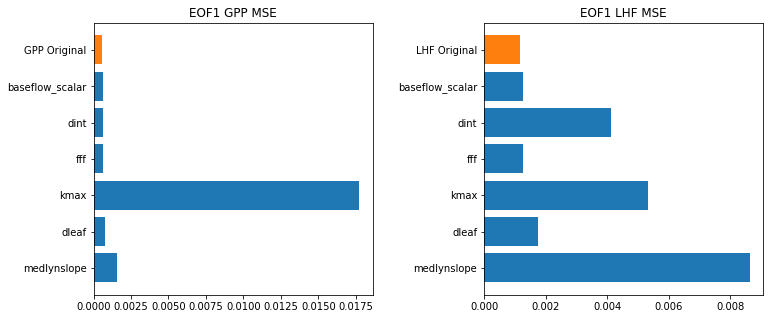

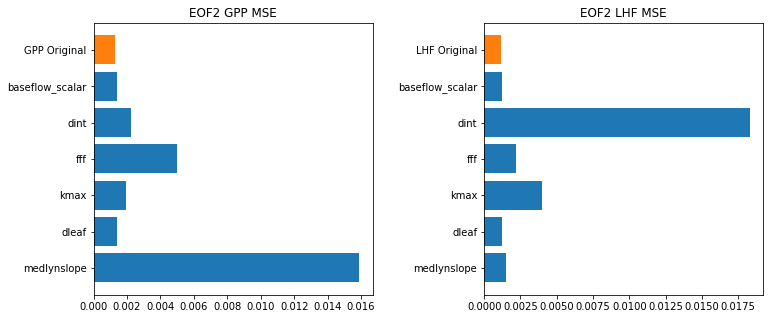

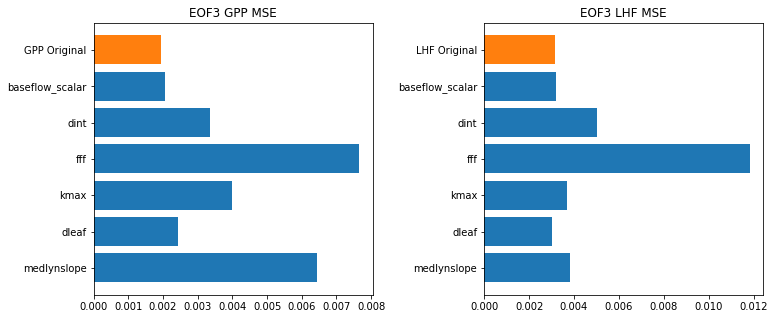

In [140]:
for m in range(nmodes):
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(1, 2, 1)
    plt.barh(np.arange(gpp_permuted.shape[0]), gpp_permuted[:,m])
    plt.barh(gpp_permuted.shape[0], gpp_original[m])
    plt.yticks(np.arange(gpp_permuted.shape[0] + 1),
        in_vars + ["GPP Original"])
    mode=m+1
    plt.title("EOF%i GPP MSE" %mode)
    plt.subplot(1, 2, 2)
    plt.barh(np.arange(lhf_permuted.shape[0]), lhf_permuted[:,m])
    plt.barh(lhf_permuted.shape[0], lhf_original[m])
    plt.yticks(np.arange(lhf_permuted.shape[0] + 1),
        in_vars + ["LHF Original"])
    plt.title("EOF%i LHF MSE" %mode)    
    plt.savefig('variable_importance_GPP_LHF_SVD_mode%i.pdf' %mode)

Try defining feature importance by setting one parameter at a time to fixed scaling value (instead of random shuffling existing values)

In [135]:
def permutation_feature_importance_v2(input_data, output_data, model, score=mse_preds):
    model_preds = model.predict(input_data)
    original_error = score(output_data, model_preds)
    permuted_scores = np.zeros((input_data.shape[1], nmodes))
    permuted_data = np.copy(input_data)
    for c in range(input_data.shape[1]):
        permuted_data[:, c] = 0.5*np.ones(input_data.shape[0])
        permuted_preds = model.predict(permuted_data)                                                                                                                     
        permuted_scores[c, :] = score(output_data,permuted_preds)
        permuted_data[:, c] = input_data[:, c]
    return original_error, permuted_scores

In [136]:
gpp_original_v2, gpp_permuted_v2 = permutation_feature_importance_v2(inputdata,
        outputdata_GPP, model_GPP)
lhf_original_v2, lhf_permuted_v2 = permutation_feature_importance_v2(inputdata,
        outputdata_LHF, model_LHF)

In [88]:
print(gpp_original_v2, gpp_permuted_v2)

0.0012748478 [0.00484099 0.00145936 0.00602918 0.00356778 0.00187134 0.00131099]


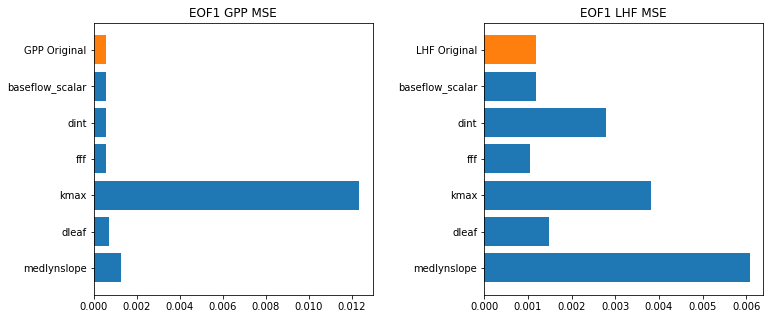

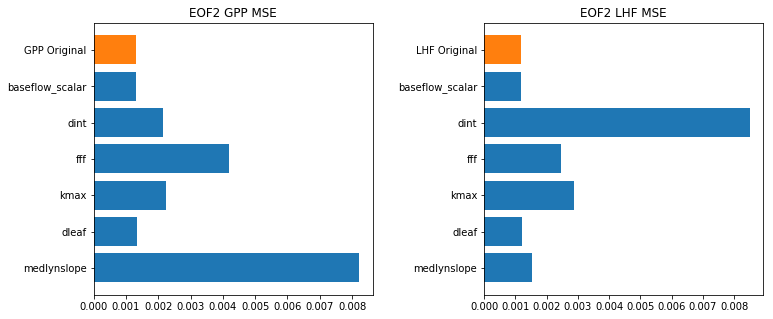

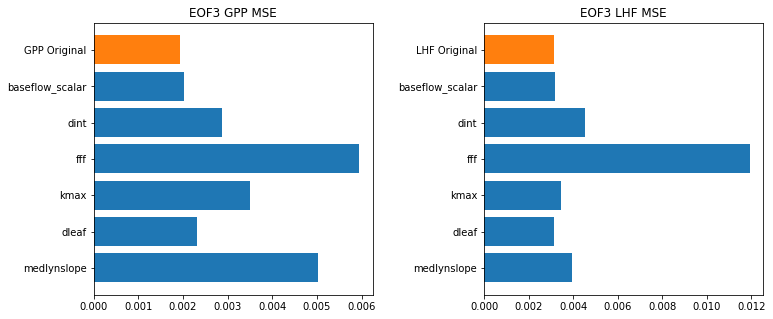

In [137]:
for m in range(nmodes):
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.4)
    plt.subplot(1, 2, 1)
    plt.barh(np.arange(gpp_permuted_v2.shape[0]), gpp_permuted_v2[:,m])
    plt.barh(gpp_permuted_v2.shape[0], gpp_original_v2[m])
    plt.yticks(np.arange(gpp_permuted_v2.shape[0] + 1),
        in_vars + ["GPP Original"])
    mode=m+1
    plt.title("EOF%i GPP MSE" %mode)
    plt.subplot(1, 2, 2)
    plt.barh(np.arange(lhf_permuted_v2.shape[0]), lhf_permuted_v2[:,m])
    plt.barh(lhf_permuted_v2.shape[0], lhf_original_v2[m])
    plt.yticks(np.arange(lhf_permuted_v2.shape[0] + 1),
        in_vars + ["LHF Original"])
    plt.title("EOF%i LHF MSE" %mode)

### NEXT: fix 5 parameters and vary one at a time. Results should be different; test parameter interactions (nonlinearities)